In [3]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
import warnings
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from yellowbrick.model_selection import ValidationCurve #pip install yellowbrick before running this command
from yellowbrick.model_selection import LearningCurve
from yellowbrick.features.importances import FeatureImportances
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
import scikitplot as skplt #pip install scikit-plot before running this command
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import itertools
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from fancyimpute import IterativeImputer #pip install fancyimpute before running this command
warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


In [3]:
filepath = "C:\\Users\\alakshminar8\\Downloads\\"
data = pd.read_csv(filepath+"training_data.csv", na_values = ['?'])
data.head()

,id,diagnosis_date,gleason_score,t_score,n_score,m_score,stage,age,race,height,...,symptoms,rd_thrpy,h_thrpy,chm_thrpy,cry_thrpy,brch_thrpy,rad_rem,multi_thrpy,survival_1_year,survival_7_years
0,1,Jun-05,4.0,T1c,N0,M0,I,86.0,4.0,66.0,...,U03,0,0,1,1,0,1,1,1,0
1,2,Feb-06,8.0,T3a,N1,M0,IV,66.0,2.0,70.0,...,"U06,S07",1,1,1,0,0,0,1,1,0
2,3,Mar-06,9.0,T1a,N0,M0,IIB,84.0,4.0,69.0,...,"U01,U02,U03,S10",1,1,0,0,1,1,1,1,1
3,4,Feb-05,8.0,T2b,N0,M0,IIB,86.0,3.0,69.0,...,"U01,U02,S10,O11",0,0,0,1,0,1,1,0,0
4,5,Dec-01,8.0,T4,N0,M0,IV,78.0,4.0,70.0,...,"U01,U03,U05,S07",1,1,1,0,0,0,1,1,0


### Exploring the data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15385 entries, 0 to 15384
Data columns (total 33 columns):
id                      15385 non-null int64
diagnosis_date          15385 non-null object
gleason_score           15065 non-null float64
t_score                 15385 non-null object
n_score                 15385 non-null object
m_score                 15385 non-null object
stage                   15385 non-null object
age                     14637 non-null float64
race                    15220 non-null float64
height                  14021 non-null float64
weight                  14068 non-null float64
family_history          13799 non-null float64
first_degree_history    13799 non-null float64
previous_cancer         13799 non-null float64
smoker                  13799 non-null float64
side                    15385 non-null object
tumor_diagnosis         15082 non-null float64
tumor_6_months          5322 non-null float64
tumor_1_year            13262 non-null float64
psa_dia

### There are 15385 observations and 33 columns in the dataset

In [5]:
percentage_missing = (data.isnull().sum()*100)/(len(data))
percentage_missing.sort_values(ascending=False, inplace = True)
percentage_missing.drop(percentage_missing[percentage_missing==0].index, inplace = True)

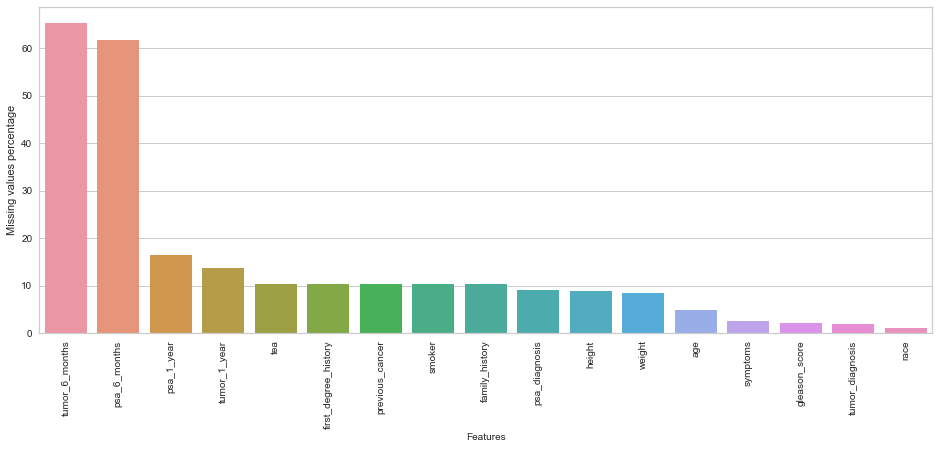

In [6]:
ax = plt.subplots(figsize = (16,6))
plt.xlabel('Features', fontsize=10)
plt.xticks(rotation = 90)
plt.ylabel('Missing values percentage')
sn.barplot(x = percentage_missing.index, y = percentage_missing)
plt.show()

### Because of high percentage of missing values, columns 'psa_6_months' and 'tumor_6_months' are removed. The reason I do not want to impute these columns is that the percentage of missing values is so high that imputing values is synonymous to introducing synthetic data. Also the columns 'id', 'diagnosis_date' can be removed as they do not play any role in our prediction.

In [7]:
data.drop(['id','diagnosis_date','psa_6_months','tumor_6_months'], axis=1, inplace=True)

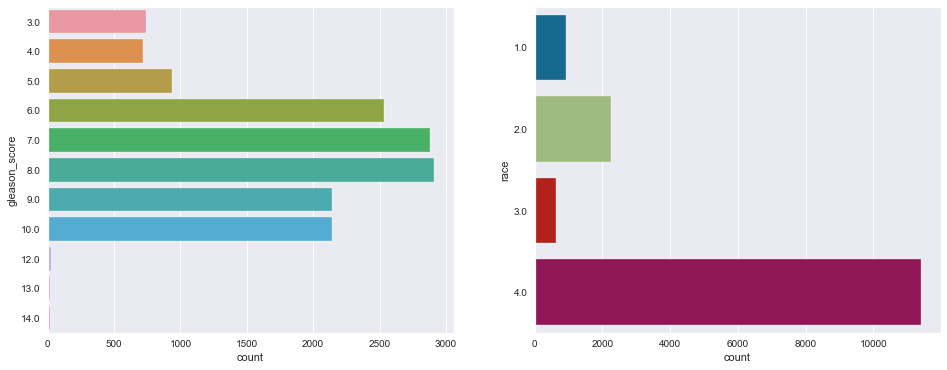

In [8]:
sn.set_style('darkgrid')
fig,ax = plt.subplots(1,2,figsize=(16,6))
sn.countplot(y="gleason_score",data=data, ax=ax[0])
sn.countplot(y="race",data=data, ax=ax[1])

plt.show()

### Cases with a gleason score of above 10 are almost negligible. Most of the cases belong to race 4 and hence we expect race to not play a major role in prediction as it offers very low variation

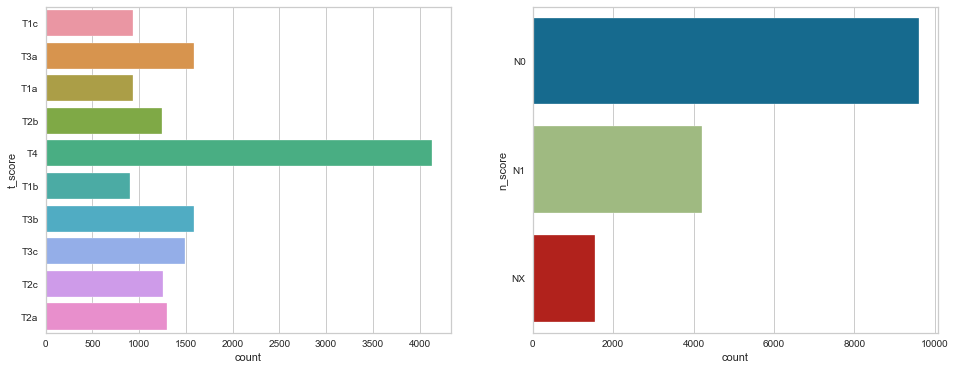

In [9]:
sn.set_style('whitegrid')

fig,ax = plt.subplots(1,2,figsize=(16,6))
sn.countplot(y = "t_score", data = data, ax = ax[0])
sn.countplot(y = "n_score", data = data, ax = ax[1])
plt.show()

### More than 50% of the cases have n_score as N0 and hence this variable may not have an impact on prediction

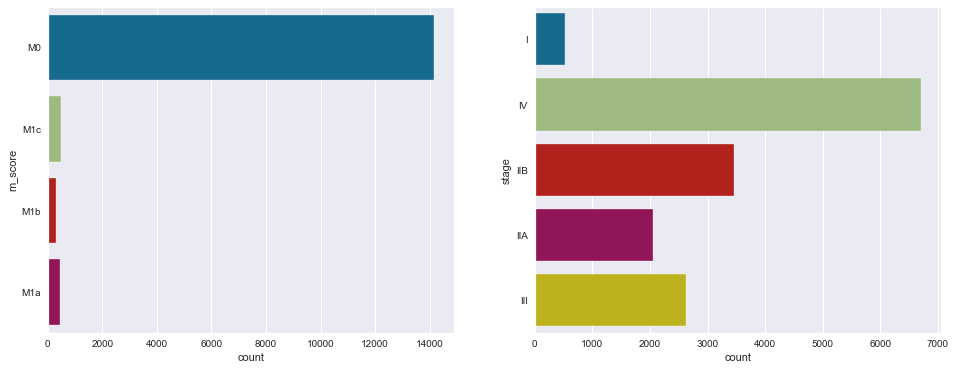

In [10]:
sn.set_style('darkgrid')

fig,ax = plt.subplots(1,2,figsize=(16,6))
sn.countplot(y = "m_score", data = data, ax = ax[0])
sn.countplot(y = "stage", data = data, ax = ax[1])
plt.show()

### m_score will not have an impact on prediction whereas stage might offer some valuable information

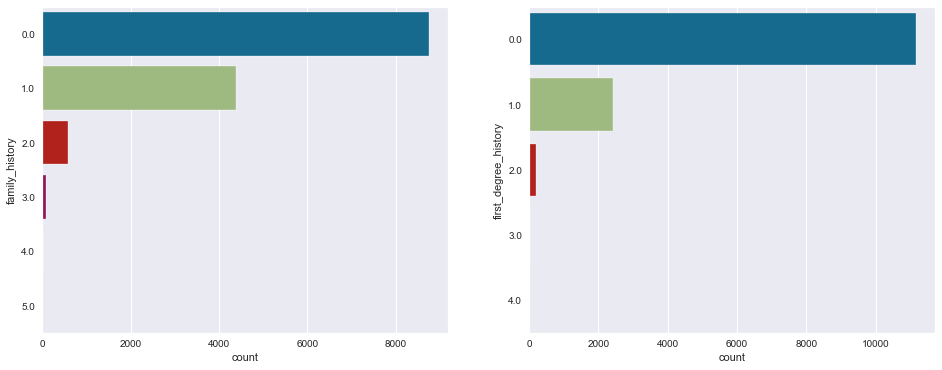

In [11]:
sn.set_style('darkgrid')

fig,ax = plt.subplots(1,2,figsize=(16,6))
sn.countplot(y = "family_history", data = data, ax = ax[0])
sn.countplot(y = "first_degree_history", data = data, ax = ax[1])
plt.show()

### More than 90% of the cases in both variables fall under 2 specific categories and hence these 2 variables might not divulge much information.

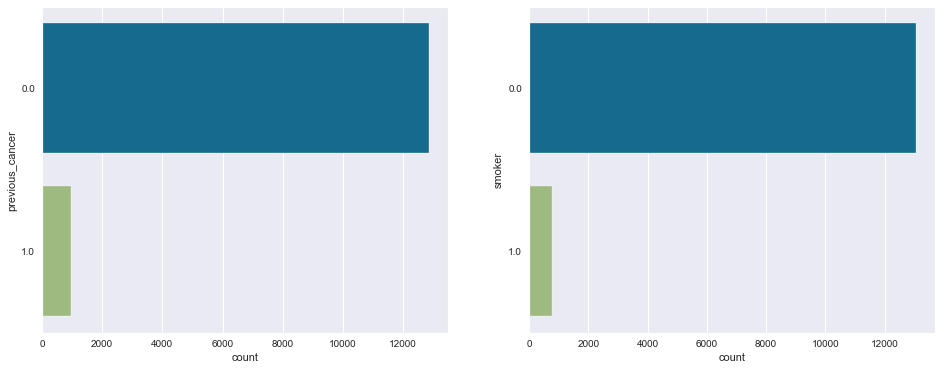

In [12]:
sn.set_style('darkgrid')

fig,ax = plt.subplots(1,2,figsize=(16,6))
sn.countplot(y = "previous_cancer", data = data, ax = ax[0])
sn.countplot(y = "smoker", data = data, ax = ax[1])
plt.show()

### More than 90% of the cases in both variables fall under a specific category and hence these 2 variables might not divulge much information.

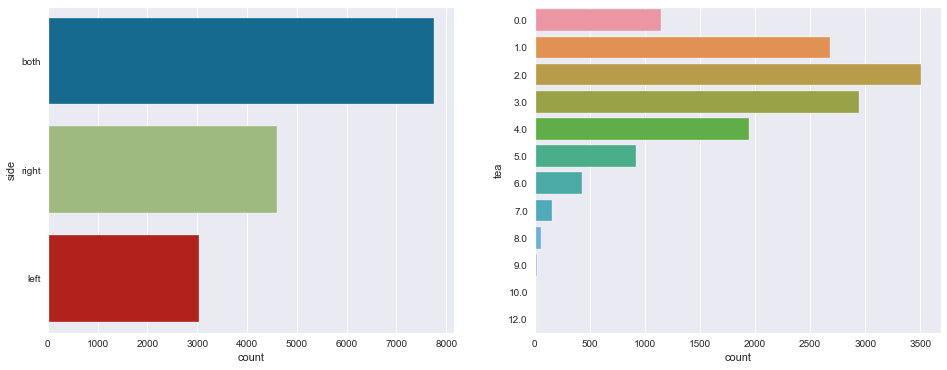

In [13]:
sn.set_style('darkgrid')

fig,ax = plt.subplots(1,2,figsize=(16,6))
sn.countplot(y = "side", data = data, ax = ax[0])
sn.countplot(y = "tea", data = data, ax = ax[1])
plt.show()

### There is significant variation in the 2 variables and it is worth introspecting them

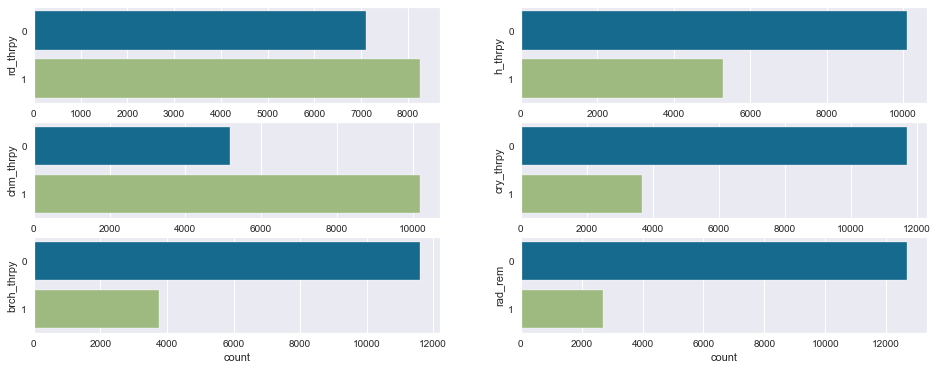

In [14]:
sn.set_style('darkgrid')

fig,ax = plt.subplots(3,2,figsize=(16,6))
sn.countplot(y = "rd_thrpy", data = data, ax = ax[0,0])
sn.countplot(y = "h_thrpy", data = data, ax = ax[0,1])
sn.countplot(y = "chm_thrpy", data = data, ax = ax[1,0])
sn.countplot(y = "cry_thrpy", data = data, ax = ax[1,1])
sn.countplot(y = "brch_thrpy", data = data, ax = ax[2,0])
sn.countplot(y = "rad_rem", data = data, ax = ax[2,1])
plt.show()

### Variables rad_rem, cry_thrpy and brch_thrpy has very little positive instances compared to negative instances and hence may be not useful for our predictions

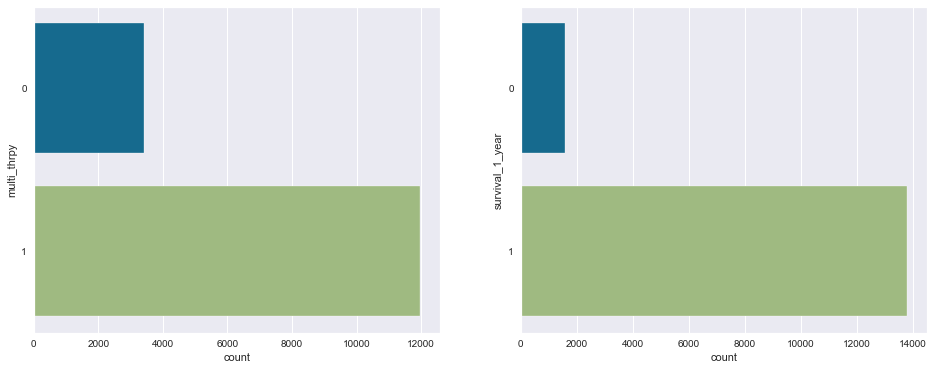

In [15]:
sn.set_style('darkgrid')

fig,ax = plt.subplots(1,2,figsize=(16,6))
sn.countplot(y = "multi_thrpy", data = data, ax = ax[0])
sn.countplot(y = "survival_1_year", data = data, ax = ax[1])

### Multi_thrpy has a lot of positive instances but significantly less number of negative instances. This dataset also comprises of a high number of 1-year survival instances which may not turn out to be significant

### Introducing a new variable BMI and removing height and weight

In [16]:
data['BMI'] = round((data['weight']*703)/(data['height']**2),0)
data.drop(['height','weight'], axis=1, inplace = True)

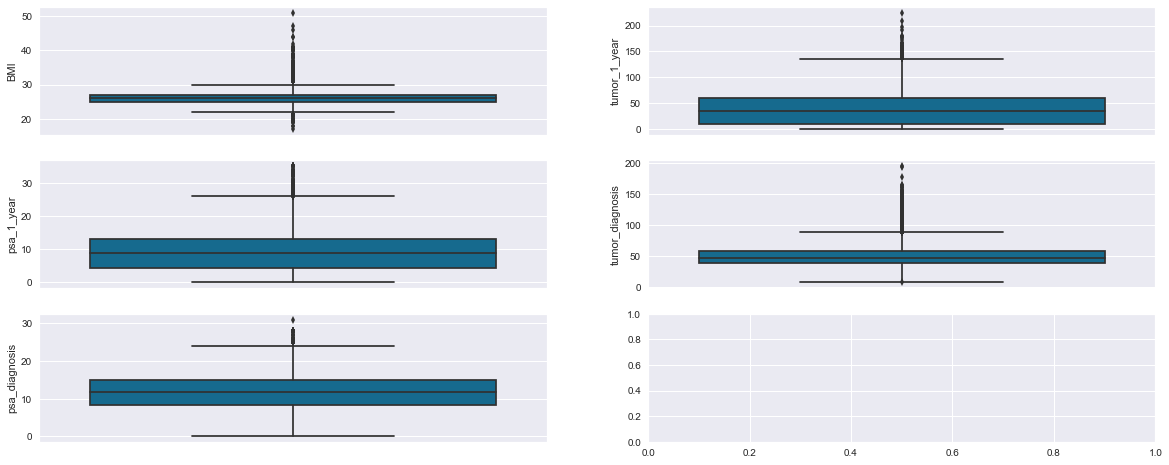

In [17]:
sn.set_style('darkgrid')

fig,ax = plt.subplots(3,2,figsize=(20,8))
sn.boxplot(y = "BMI", data = data, ax = ax[0][0], orient = 'v')
sn.boxplot(y = "tumor_1_year", data = data, ax = ax[0][1], orient = 'v')
sn.boxplot(y = "psa_1_year", data = data, ax = ax[1][0], orient = 'v')
sn.boxplot(y = "tumor_diagnosis", data = data, ax = ax[1][1], orient = 'v')
sn.boxplot(y = "psa_diagnosis", data = data, ax = ax[2][0], orient = 'v')
plt.show()

In [18]:
numeric_cols = ['BMI','tumor_1_year','psa_1_year','tumor_diagnosis','psa_diagnosis']
lst = []
for j in numeric_cols:
    skew = data[j].skew()
    lst.append(skew)
    
skewness = pd.DataFrame({'Skew' :lst}, index = numeric_cols)
skewness.sort_values

<bound method DataFrame.sort_values of                      Skew
BMI              1.689537
tumor_1_year     0.747508
psa_1_year       0.533220
tumor_diagnosis  1.417540
psa_diagnosis    0.179342>

### Variables BMI, tumor_diagnosis, psa_1_year and tumor_1_year are positively skewed and hence need transformations. psa_1_year and tumor_1_year are moderately skewed and hence will apply square root. The other 2 variables require a logarithmic transformation

In [19]:
data['BMI'] = np.log10(data['BMI'])
data['tumor_diagnosis'] = np.log10(data['tumor_diagnosis'])
data['psa_1_year'] = np.sqrt(data['psa_1_year'])
data['tumor_1_year'] = np.sqrt(data['tumor_1_year'])

### Converting some numerical columns into ordinal variables as the indicators below specify how fast and how far the cancer spreads. Hence, it would not be be right to treat them as numerical variables as the order is very important in predicting cancer survival

In [20]:
data['t_score'] = pd.Categorical(data['t_score'], categories = ['T1a','T1b','T1c','T2a','T2b','T2c','T3a','T3b','T3c','T4'], 
                ordered = True).codes
data['n_score'] = pd.Categorical(data['n_score'], categories = ['N0','N1','NX'], ordered = True).codes
data['m_score'] = pd.Categorical(data['m_score'], categories = ['M0','M1a','M1b','M1c'], ordered = True).codes
data['stage'] = pd.Categorical(data['stage'], categories = ['I','IIA','IIB','III','IV'], ordered = True).codes

In [21]:
data['gleason_score'] = data['gleason_score'].astype(CategoricalDtype(ordered = True))
data['t_score'] = data['t_score'].astype(CategoricalDtype(ordered = True))
data['n_score'] = data['n_score'].astype(CategoricalDtype(ordered = True))
data['m_score'] = data['m_score'].astype(CategoricalDtype(ordered = True))
data['stage'] = data['stage'].astype(CategoricalDtype(ordered = True))

In [22]:
data['t_score'].dtype

CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ordered=True)

### Checking for correlation between variables in the dataset

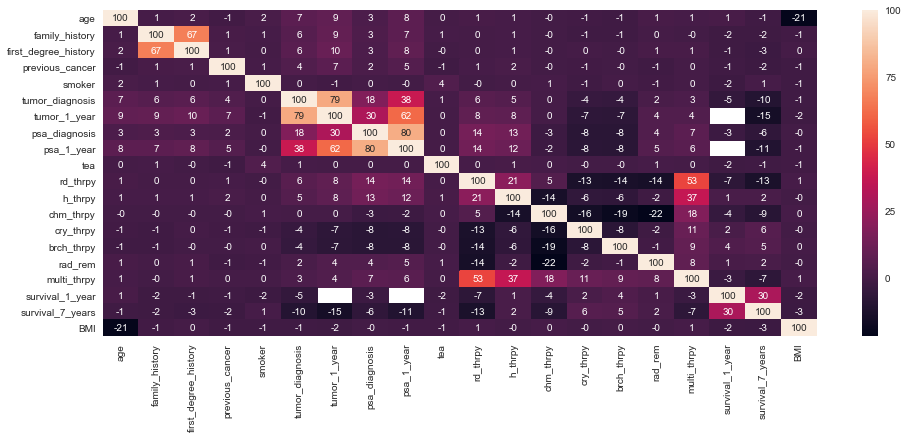

In [23]:
corr_columns = data.drop(['race','side'], axis = 1)
correlations = corr_columns.corr(method='pearson')
sn.set_style('white')
plt.figure(figsize=(16,6))

# Plot heatmap of annotated correlations
sn.heatmap(correlations*100, annot=True, fmt='.0f' )

### Variables (tumor_1_year,tumor_diagnosis) and (psa_1_year,psa_dignosis) are highly correlated with each other(greater than 70%) and it would be prudent if we use one of these variables in our analysis.

### Handling of symptoms column

In [24]:
symptom = data['symptoms'].astype(str)
symp = []
for line in symptom:
    symp.append((line.strip()).split(','))

In [25]:
final = list(itertools.chain.from_iterable(symp))

### Creating a unique list of symptoms

In [26]:
mylist = list(set(final))
output = set()
for x in mylist:
    output.add(x)
print(output)

{'O08', 'P03', 'S07', 'P01', 'P02', 'O01', 'U06', 'nan', 'O09', 'U03', 'U02', 'U05', 'U01', 'O11', 'S04', 'S10', 'O10'}


In [27]:
j = 1
dic = {}
for i in output:
    col = []
    for line in symp:
        col.append(int(i in line))
    dic[i] = pd.Series(col)
    j+=1

In [28]:
out = pd.DataFrame(dic)

In [29]:
out.drop(['nan'], axis = 1, inplace = True)

In [30]:
data = pd.concat([data, out], axis=1)

### Creating dummy variables for race and side

In [31]:
data_race = pd.get_dummies(data['race'], prefix = 'race')
data_side = pd.get_dummies(data['side'], prefix = 'side')

In [32]:
data = pd.concat([data, data_race, data_side], axis=1)
data.drop(['race','side','symptoms'], axis = 1, inplace = True)

### Imputing data with mean, mode and median might be useful for certain variables but the columns are not independent and it would be right to use some kind of a regression, classification or KNN algorithm to impute these missing values. Hence, I have used a package called MICE(Iterative Imputer). It basically runs a predictive algorithm to fill missing values by regressing a column with other columns in the dataset.

In [33]:
data_final = IterativeImputer(random_state = 100, min_value = 0, sample_posterior = True).fit_transform(data)

In [34]:
data_new = pd.DataFrame(data_final, columns = data.columns, index = data.index)

In [35]:
data_new.to_csv('impute.csv')

In [36]:
data_new.describe()

,gleason_score,t_score,n_score,m_score,stage,age,family_history,first_degree_history,previous_cancer,smoker,...,S04,S10,O10,race_1.0,race_2.0,race_3.0,race_4.0,side_both,side_left,side_right
count,15385.000000,15385.000000,15385.000000,15385.000000,15385.000000,15385.000000,15385.000000,15385.000000,15385.000000,15385.000000,...,15385.000000,15385.000000,15385.000000,15385.000000,15385.000000,15385.000000,15385.000000,15385.000000,15385.000000,15385.000000
mean,7.295878,5.704192,0.476958,0.160806,2.841469,76.904807,0.444555,0.228687,0.075502,0.062041,...,0.247839,0.059539,0.008645,0.059669,0.147156,0.040624,0.741826,0.504452,0.196815,0.298733
std,1.934394,2.935881,0.672334,0.601403,1.216500,9.705004,0.607856,0.454109,0.246408,0.222615,...,0.431772,0.236638,0.092578,0.236879,0.354273,0.197424,0.437644,0.499996,0.397604,0.457717
min,2.251564,0.000000,0.000000,0.000000,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,3.000000,0.000000,0.000000,2.000000,71.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,6.000000,0.000000,0.000000,3.000000,78.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,9.000000,9.000000,1.000000,0.000000,4.000000,84.000000,1.000000,0.005662,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,14.000000,9.000000,2.000000,3.000000,4.000000,108.275356,5.000000,4.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Imputation will result in filling decimal values to columns which should have discrete integers. We will identify those columns and round them off to the nearest integer.

In [37]:
decimal_cols = ['gleason_score','tea','smoker','first_degree_history','family_history','previous_cancer','age']

for a in decimal_cols:
    data_new[a] = round(data_new[a],0).astype(int)

### Logistic Regression Model

In [49]:
x = data_new.drop(["survival_7_years"], axis=1)
y = data_new["survival_7_years"]

In [39]:
x_new = sm.add_constant(x)
logit = sm.Logit(y, x_new)
result = logit.fit()
print(result.summary())

         Current function value: 0.578303
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:       survival_7_years   No. Observations:                15385
Model:                          Logit   Df Residuals:                    15338
Method:                           MLE   Df Model:                           46
Date:                Mon, 22 Apr 2019   Pseudo R-squ.:                  0.1545
Time:                        10:38:15   Log-Likelihood:                -8897.2
converged:                      False   LL-Null:                       -10523.
                                        LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -25.3567   4.67e+06  -5.43e-06      1.000   -9.15e+06    9.15e+06
gleason_score           -0.0956    

### With the extermely large standard errors, it can be said that 'side_both','side_left' and 'side_right' may be responsible for the quasi-separation. Also, survival_1_year seems to be a possible 'perfect predictor' column as it also has high standard errors.

### Apart from these issues, multicollinearity can cause a significant change in the standard errors and we will evaluate it to remove potential variables.

In [40]:
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["Variables"] = x.columns

In [41]:
vif.round(1)

,vif,Variables
0,1.4,gleason_score
1,3.2,t_score
2,1.3,n_score
3,4.1,m_score
4,4.5,stage
5,1.1,age
6,1.7,family_history
7,1.7,first_degree_history
8,1.0,previous_cancer
9,1.0,smoker


### I decided to remove columns that have a vif value of greater than 5

In [42]:
collinear_cols = vif[vif['vif'] > 5.0]

In [43]:
collinear_cols

,vif,Variables
40,6.230535,race_1.0
41,12.581439,race_2.0
43,18.155295,race_4.0
44,1178.408468,side_both
45,460.732245,side_left
46,697.765511,side_right


### Apart from this, I also removed 'survival_1_year' as it turned out to be a perfect predictor variable leading to quasi-separation

In [44]:
x_reg = data_new.drop(['survival_7_years','survival_1_year','race_1.0','race_2.0','race_4.0','side_both','side_left','side_right'], 
                  axis=1)
y_reg = data_new['survival_7_years']

In [45]:
x_new = sm.add_constant(x_reg)
logit = sm.Logit(y_reg, x_new)
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.631507
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       survival_7_years   No. Observations:                15385
Model:                          Logit   Df Residuals:                    15344
Method:                           MLE   Df Model:                           40
Date:                Mon, 22 Apr 2019   Pseudo R-squ.:                 0.07668
Time:                        10:38:55   Log-Likelihood:                -9715.7
converged:                       True   LL-Null:                       -10523.
                                        LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.3553      0.810      4.142      0.000       1.768       4.943

### Significant Variables: gleason_score, t_score, n_score, stage, tumor_diagnosis, tumor_1_year, psa_diagnosis, psa_1_year, rd_thrpy, h_thrpy, rad_rem, brch_thrpy, multi_thrpy,BMI.
### Key Symptoms to Monitor: U05, P02, P03, P01, S10, O09 and O08

### Feature Extraction using Random Forest Cross Validation

In [50]:
clf = RandomForestClassifier(random_state = 100, n_jobs = -1, oob_score = True)
rfecv = RFECV(clf, step=1, cv = 5, scoring = 'f1', n_jobs = -1)
rfecv = rfecv.fit(x, y)

In [51]:
print('Optimal number of features:', rfecv.n_features_)
print('Support:', x.columns[rfecv.support_])
print('Feature rankings:', rfecv.ranking_)

Optimal number of features: 38
Support: Index(['gleason_score', 't_score', 'n_score', 'm_score', 'stage', 'age',
       'family_history', 'first_degree_history', 'previous_cancer', 'smoker',
       'tumor_diagnosis', 'tumor_1_year', 'psa_diagnosis', 'psa_1_year', 'tea',
       'rd_thrpy', 'h_thrpy', 'chm_thrpy', 'cry_thrpy', 'brch_thrpy',
       'rad_rem', 'multi_thrpy', 'survival_1_year', 'BMI', 'S07', 'U06', 'U03',
       'U02', 'U05', 'U01', 'O11', 'S04', 'S10', 'race_2.0', 'race_4.0',
       'side_both', 'side_left', 'side_right'],
      dtype='object')
Feature rankings: [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  9 10  1  4  5  6  1  7  1  1  1  1  1  1  1  8  2  1  3  1  1  1  1]


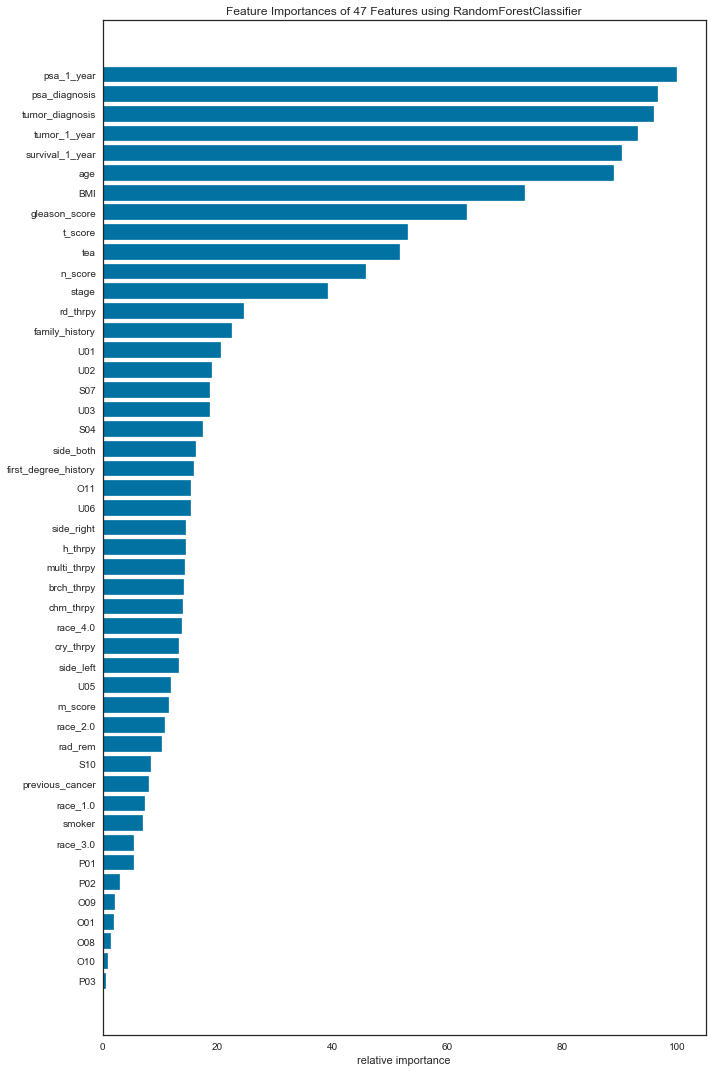

In [52]:
fig = plt.figure(figsize = (10,15))
ax = fig.add_subplot()
viz = FeatureImportances(clf, ax=ax)
viz.fit(x, y)
viz.poof()

In [53]:
np.sort(clf.feature_importances_)

array([0.00047915, 0.00065887, 0.00106383, 0.001486  , 0.00156436,
       0.00226031, 0.00410399, 0.00415089, 0.00539084, 0.00557277,
       0.00618587, 0.00644625, 0.00784456, 0.0082543 , 0.00879429,
       0.0091493 , 0.01016798, 0.01020927, 0.01058621, 0.01072356,
       0.01077362, 0.01102856, 0.01114934, 0.01116803, 0.01177638,
       0.01183874, 0.01216715, 0.01250601, 0.01334311, 0.0142574 ,
       0.0143533 , 0.01457197, 0.01581135, 0.01730772, 0.01887703,
       0.03000154, 0.03508429, 0.03966527, 0.04068437, 0.04863271,
       0.05642689, 0.06830519, 0.06934972, 0.07152393, 0.07357411,
       0.07407388, 0.07665578])

### Although we have the visualization for all 48 features in the dataset, we are going to use only the 40 optimal features that we have extracted using Random Forest.

In [54]:
x_rfe = rfecv.transform(x)

In [55]:
def classifier_metrics(estimator,y_pred):
    class_metrics = {'Accuracy' : metrics.accuracy_score(y, y_pred),
                     'Precision' : metrics.precision_score(y, y_pred),
                     'Recall' : metrics.recall_score(y, y_pred),
                     'F1 Score' : metrics.f1_score(y, y_pred)
                    }


    df_metrics = pd.DataFrame.from_dict(class_metrics, orient='index')
    print('\nConfusion Matrix:')
    skplt.metrics.plot_confusion_matrix(y, y_pred)
    
    print('\nClassification Report:')
    print(metrics.classification_report(y,y_pred,digits=2))
    
    print('\nMetrics:')
    print(df_metrics)
    
    return  df_metrics

In [56]:
def plot_roc(model,x_test,y):
    model_proba = cross_val_predict(model, x_test, y, cv=5, n_jobs=-1, verbose=1, method = 'predict_proba')
    fig = plt.figure()
    ax1 = fig.add_subplot()
    skplt.metrics.plot_roc(y,model_proba ,figsize = (15,7),title_fontsize='large',text_fontsize='large')                
    return None

In [57]:
def precision_recall(model,x_test,y):
    model_proba = cross_val_predict(model, x_test, y, cv=5, n_jobs=-1, verbose=1, method = 'predict_proba')
    fig = plt.figure()
    ax1 = fig.add_subplot()
    skplt.metrics.plot_precision_recall(y,model_proba,figsize = (15,7),title_fontsize='large',text_fontsize='large')                 
    return None

### Logistic Regression

In [59]:
log = LogisticRegression(solver = 'liblinear', random_state = 100, penalty = 'l1', n_jobs = -1, class_weight={1: 1.314})
param_grid = {'C':[0.01,0.05,0.1]}
grid_search_log= GridSearchCV(log,param_grid, cv=5, scoring = 'f1', n_jobs=-1, verbose = 2)
grid_search_log.fit(x_rfe,y)

print("Best Parameters : {}".format(grid_search_log.best_params_))
print("Best cross_val score : {}".format(grid_search_log.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    2.8s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.9s finished


Best Parameters : {'C': 0.05}
Best cross_val score : 0.6489704325470331


In [60]:
logreg = LogisticRegression(solver = 'liblinear', random_state = 100, penalty = 'l1', n_jobs = -1, C=0.05, class_weight={1: 1.314})
logreg.fit(x_rfe,y)
log_pred = cross_val_predict(logreg, x_rfe, y, cv=5, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished



Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.59      0.66      8734
         1.0       0.58      0.74      0.65      6651

   micro avg       0.65      0.65      0.65     15385
   macro avg       0.66      0.66      0.65     15385
weighted avg       0.67      0.65      0.65     15385


Metrics:
                  0
Accuracy   0.654014
Precision  0.577989
Recall     0.739889
F1 Score   0.648994


,0
Accuracy,0.654014
Precision,0.577989
Recall,0.739889
F1 Score,0.648994


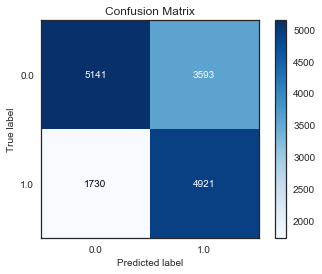

In [61]:
classifier_metrics(logreg,log_pred)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


<Figure size 432x288 with 0 Axes>

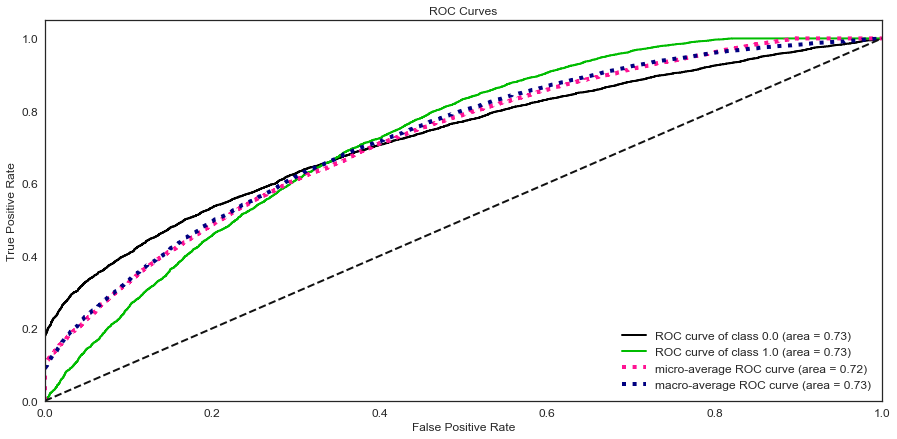

In [62]:
plot_roc(logreg,x_rfe,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


<Figure size 432x288 with 0 Axes>

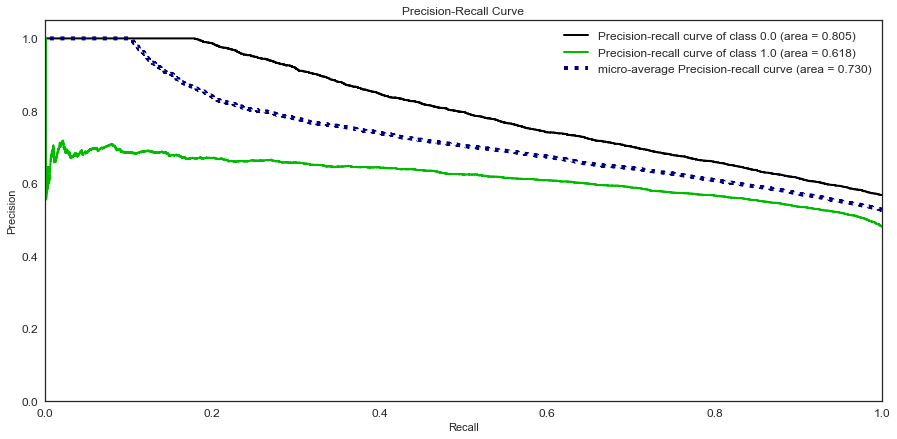

In [63]:
precision_recall(logreg,x_rfe,y)

### Random Forest

In [65]:
ranf = RandomForestClassifier(random_state=100, oob_score=True, n_jobs=-1, class_weight={1: 1.314}, criterion = 'gini')
param_grid = {'n_estimators':[50,100,150], 'max_features':[0.3,0.6,0.9], 'max_depth':[3,6,9], 'min_samples_leaf':[25, 50, 75]}
grid_search_ran= GridSearchCV(ranf,param_grid, cv=5, scoring = 'f1', n_jobs=-1, verbose=2)
grid_search_ran.fit(x_rfe,y)

print("Best Parameters : {}".format(grid_search_ran.best_params_))
print("Best cross_val score : {}".format(grid_search_ran.best_score_))

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  2.1min finished


Best Parameters : {'max_depth': 6, 'max_features': 0.9, 'min_samples_leaf': 50, 'n_estimators': 100}
Best cross_val score : 0.6885853628201704


### We will plot the learning curve to see how well the model performs as the number of instances increase.

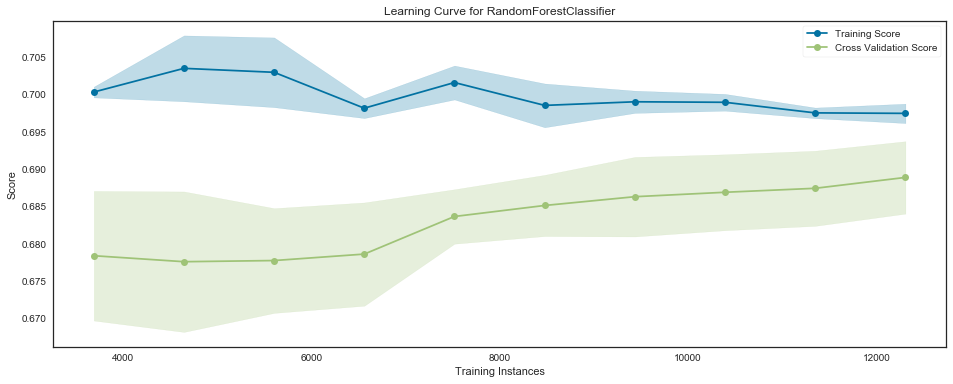

In [66]:
ranfor = RandomForestClassifier(random_state=100, oob_score=True, n_jobs=-1, class_weight={1: 1.314}, criterion = 'gini',
                                 n_estimators = 100, max_features = 0.9, max_depth = 6, min_samples_leaf = 50)
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(111)
cv = StratifiedKFold(5)
sizes = np.linspace(0.3, 1.0, 10)
viz = LearningCurve( ranfor, cv=cv, train_sizes=sizes, scoring='f1', n_jobs=-1)
viz.fit(x_rfe, y)
viz.poof()

### We can see that the model learns very well as the cross validation score is converging with the training score.

In [67]:
ranfor.fit(x_rfe,y)
ranfor_pred = cross_val_predict(ranfor, x_rfe, y, cv=5, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished



Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.54      0.65      8734
         1.0       0.58      0.85      0.69      6651

   micro avg       0.67      0.67      0.67     15385
   macro avg       0.70      0.69      0.67     15385
weighted avg       0.72      0.67      0.67     15385


Metrics:
                  0
Accuracy   0.669418
Precision  0.580845
Recall     0.845286
F1 Score   0.688549


,0
Accuracy,0.669418
Precision,0.580845
Recall,0.845286
F1 Score,0.688549


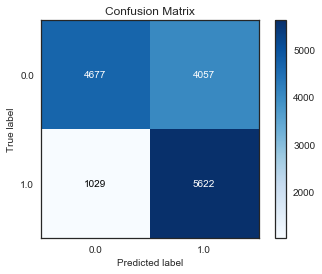

In [68]:
classifier_metrics(ranfor,ranfor_pred)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s finished


<Figure size 432x288 with 0 Axes>

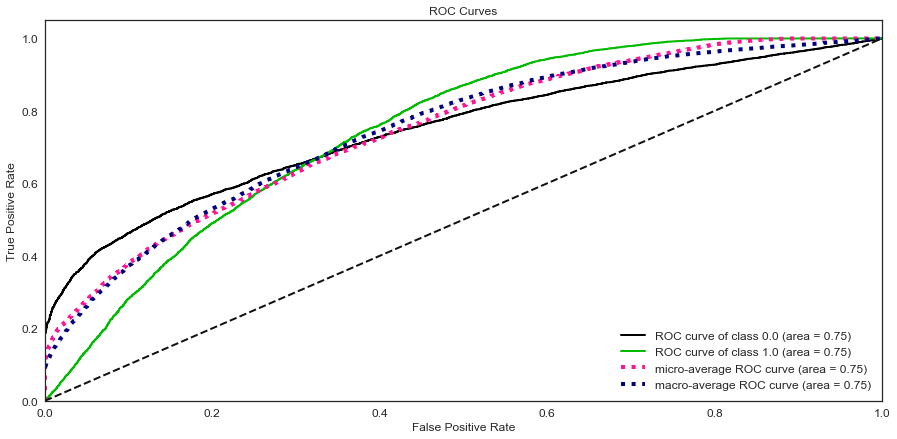

In [84]:
plot_roc(ranfor,x_rfe,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished


<Figure size 432x288 with 0 Axes>

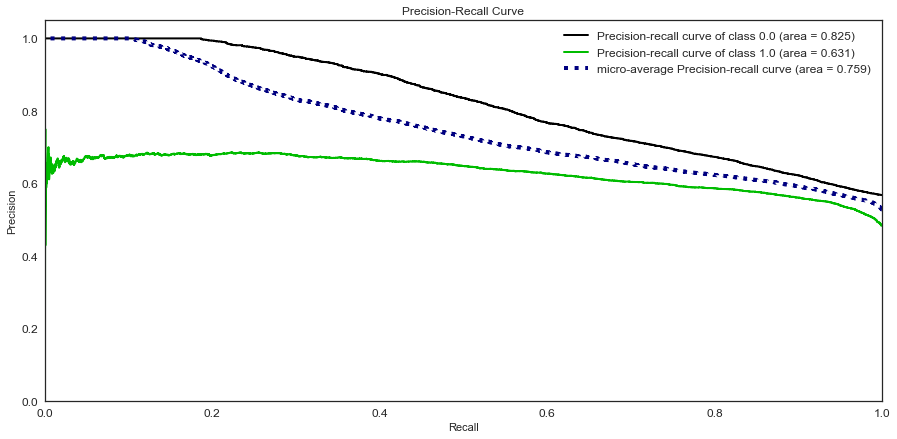

In [85]:
precision_recall(ranfor,x_rfe,y)

### The recall score and f1 score has increased by 10% and 4% respectively in the random forest model compared to logistic regression model. With more hyperparameter tuning we can fine tune the models to improve accuracy. We can even use different boosting algorithms to improve model performance.

### XGBoost

In [90]:
xgb = XGBClassifier(random_state = 100, n_jobs = -1, silent = 1, scale_pos_weight = 2)
param_grid = {'n_estimators':[100,150,200], 'learning_rate':[0.05,0.1,0.2], 'max_depth':[1,3,6], 'min_child_weight':[3,6,9]}

grid_search_xgb= GridSearchCV(xgb, param_grid, cv=5, scoring = 'f1', n_jobs=-1, verbose = 2)
grid_search_xgb.fit(x_rfe,y)

print("Best Parameters : {}".format(grid_search_xgb.best_params_))
print("Best cross_val score : {}".format(grid_search_xgb.best_score_))

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  3.0min finished


Best Parameters : {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 150}
Best cross_val score : 0.69443227144968


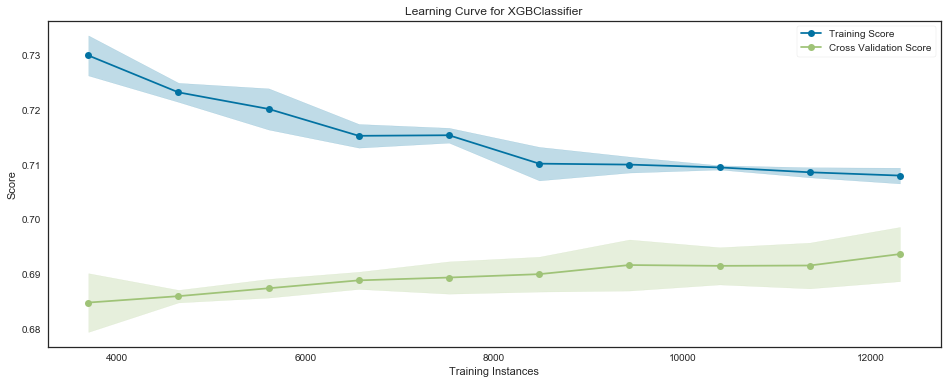

In [91]:
xgboost = XGBClassifier(random_state=100, n_jobs=-1, n_estimators = 150, learning_rate = 0.1, max_depth = 3, 
                        min_child_weight = 6, scale_pos_weight = 2)
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(111)
cv = StratifiedKFold(5)
sizes = np.linspace(0.3, 1.0, 10, endpoint = True)
viz = LearningCurve(xgboost, cv=cv, train_sizes=sizes, scoring='f1', n_jobs=-1)
viz.fit(x_rfe, y)
viz.poof()

In [92]:
xgboost = XGBClassifier(random_state=100, n_jobs=-1, n_estimators=150, learning_rate = 0.1, max_depth = 3, min_child_weight = 6,
                       scale_pos_weight = 2)
xgboost.fit(x_rfe,y)
xgb_pred = cross_val_predict(xgboost, x_rfe, y, cv=3, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished



Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.46      0.60      8734
         1.0       0.56      0.90      0.69      6651

   micro avg       0.65      0.65      0.65     15385
   macro avg       0.71      0.68      0.65     15385
weighted avg       0.73      0.65      0.64     15385


Metrics:
                  0
Accuracy   0.651674
Precision  0.560138
Recall     0.904676
F1 Score   0.691888


,0
Accuracy,0.651674
Precision,0.560138
Recall,0.904676
F1 Score,0.691888


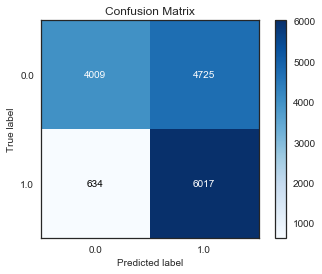

In [93]:
classifier_metrics(xgboost,xgb_pred)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished


<Figure size 432x288 with 0 Axes>

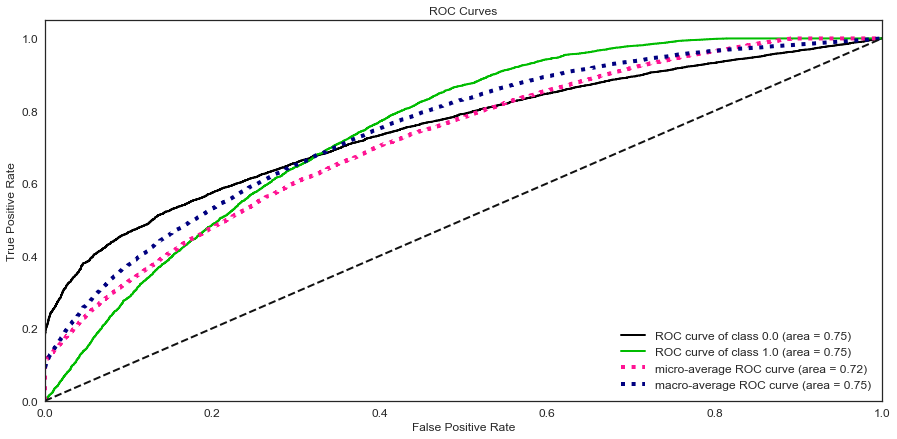

In [96]:
plot_roc(xgboost,x_rfe,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


<Figure size 432x288 with 0 Axes>

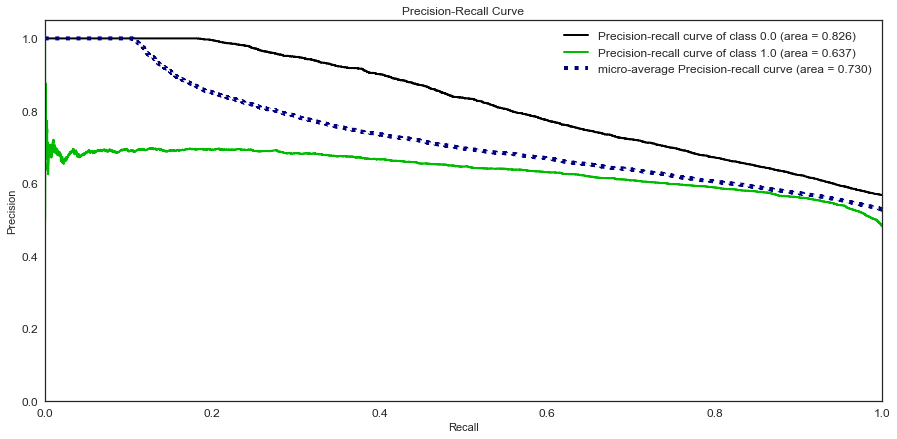

In [95]:
precision_recall(xgboost,x_rfe,y)

### XGBoost gives a very similar performance to random forest in trems of f1 score(1% increase). However, the recall score has increased by 6% compared to random forest without much decrease in precision.

### References

#### https://en.wikipedia.org/wiki/Gleason_grading_system
#### http://www.cancer.org/treatment/understandingyourdiagnosis/understandingyourpathologyreport/prostatepathology/prostate-cancer-pathology